In [1]:
import math
import numpy as np
import pandas as pd
from IPython.display import FileLink
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
from torch.optim import lr_scheduler
import torch.utils.data
import torch.utils.data.distributed
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torchvision.utils import make_grid

%matplotlib inline

In [2]:
path = 'data/dogbreeds/'
batch_size = 32
epochs = 5
num_classes = 120

In [3]:
labels = pd.read_csv(path + 'labels.csv')
sample_submission = pd.read_csv(path + 'sample_submission.csv')

In [6]:
class_counts = labels.groupby('breed').count().sort_values(by='id', ascending=False)
all_classes = list(class_counts.index)
classes = all_classes[:num_classes]
selected_labels = labels[labels['breed'].isin(classes)].reset_index(drop=True)

class_to_num = dict(zip(classes, range(num_classes)))
num_to_class = dict(zip(range(num_classes), classes))
selected_labels['class'] = [class_to_num[breed] for breed in selected_labels['breed'].values]

In [52]:
train_labels = selected_labels.sample(frac=0.7)
valid_labels = selected_labels[~selected_labels['id'].isin(train_labels['id'])]

In [53]:
train_labels = []
valid_labels = []
grouped_labels = selected_labels.groupby('breed')
max_group_size = grouped_labels.count().max()[0]

train_group_size = math.floor(max_group_size * 0.7)
valid_group_size = max_group_size - train_group_size

for name, group in grouped_labels:        
    train_group = group.sample(frac=0.7)
    valid_group = group[~group.index.isin(train_group.index)]
    
    train_oversamples = train_group.sample(train_group_size - train_group.shape[0], replace=True)
    valid_oversamples = valid_group.sample(valid_group_size - valid_group.shape[0], replace=True)
    
    train_group = pd.concat([train_group, train_oversamples])
    valid_group = pd.concat([valid_group, valid_oversamples])
    
    train_labels.append(train_group)
    valid_labels.append(valid_group)
    
train_labels = pd.concat(train_labels)
valid_labels = pd.concat(valid_labels)

In [54]:
class DogsDataset(Dataset):
    def __init__(self, root_dir, labels, transform, output_class=True):
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform
        self.output_class = output_class
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        item = self.labels.iloc[idx]
        path = '{}/{}.jpg'.format(self.root_dir, item['id'])
        image = Image.open(path).convert('RGB')

        if self.transform:
            image = self.transform(image)
            
        if not self.output_class:
            return image
        
        return image, item['class']

In [55]:
def train(model, train, valid, optimizer, criterion, epochs=1, scheduler=None):
    for epoch in range(epochs):
        print('Epoch ', epoch + 1, '/', epochs)
        
        running_loss = 0.
        running_corrects = 0.
        running_batches = 0.

        if scheduler:
            scheduler.step()
            
        model.train()
        for i, (input, target) in enumerate(train):
            input = input.cuda()
            target = target.cuda()
            input_var = torch.autograd.Variable(input)
            target_var = torch.autograd.Variable(target)

            optimizer.zero_grad()

            # compute output
            output = model(input_var)
            _, preds = torch.max(output.data, 1)
            loss = criterion(output, target_var)

            loss.backward()
            optimizer.step()
            
            running_loss += loss.data[0]
            running_corrects += torch.sum(preds == target)
            running_batches += 1.

            print('\r', 'Batch', i, 'Loss', loss.data[0], end='')
            
        train_loss = running_loss / running_batches
        train_acc = running_corrects / len(train.dataset.labels)
        print('\r', "Train Loss", train_loss, "Train Accuracy", train_acc)
            
        running_loss = 0.
        running_corrects = 0.
        running_batches = 0.

        model.eval()
        for i, (input, target) in enumerate(valid):
            input = input.cuda()
            target = target.cuda()
            input_var = torch.autograd.Variable(input, volatile=True)
            target_var = torch.autograd.Variable(target, volatile=True)

            output = model(input_var)
            _, preds = torch.max(output.data, 1)
            loss = criterion(output, target_var)

            running_loss += loss.data[0]
            running_corrects += torch.sum(preds == target)
            running_batches += 1.

        valid_loss = running_loss / running_batches
        valid_acc = running_corrects / len(valid.dataset.labels)
        #print()
        print('\r', "Val Loss", valid_loss, "Val Accuracy", valid_acc)

In [56]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.pause(0.001)

In [57]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_trans = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize,
])

val_trans = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

In [58]:
train_dataset = DogsDataset(path + 'images', train_labels, train_trans)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    DogsDataset(path + 'images', valid_labels, val_trans),
    batch_size=batch_size,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    DogsDataset(path + 'test/x', sample_submission, val_trans, output_class=False),
    batch_size=batch_size
)

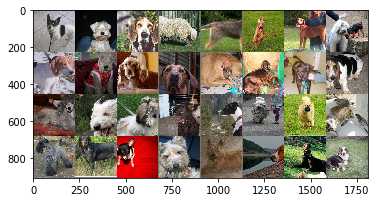

In [59]:
inputs, derp = next(iter(train_loader))
out = make_grid(inputs)
imshow(out)

In [60]:
model = models.densenet161(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, num_classes)
model = model.cuda()

criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.classifier.parameters()) #torch.optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.9)
#scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
train(model, train_loader, val_loader, optimizer, criterion, epochs=5) #, scheduler=scheduler)

Epoch  1 / 5
 Batch 175 Loss 1.2281793355941772

In [20]:
torch.save(model.state_dict(), path + 'weights.torch')

In [22]:
for param in model.parameters():
    param.requires_grad = True
    
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [28]:
train(model, train_loader, val_loader, optimizer, criterion, epochs=5, scheduler=scheduler)

Epoch  1 / 5
 Train Loss 0.2459634317593141 Train Accuracy 0.9556818181818182
 Val Loss 0.40923344213645774 Val Accuracy 0.8796052631578948
Epoch  2 / 5
 Train Loss 0.1964281177430442 Train Accuracy 0.9682765151515151
 Val Loss 0.40507717263865306 Val Accuracy 0.8828947368421053
Epoch  3 / 5
 Train Loss 0.1544639940514709 Train Accuracy 0.978125
 Val Loss 0.40090384672988544 Val Accuracy 0.8791666666666667
Epoch  4 / 5
 Train Loss 0.12696449752106811 Train Accuracy 0.984280303030303
 Val Loss 0.4022936384369443 Val Accuracy 0.8820175438596491
Epoch  5 / 5
 Batch 247 Loss 0.078139752149581916

KeyboardInterrupt: 

In [24]:
torch.save(model.state_dict(), path + 'weights.torch')

In [25]:
model.load_state_dict(torch.load(path + 'weights.torch'))
model.eval()
results = []

for i, input in enumerate(test_loader):
    input = input.cuda()
    input_var = torch.autograd.Variable(input, volatile=True)
    output = model(input_var)
    results.append(F.softmax(output, dim=1).cpu().data.numpy())
    print('\r', 'Batch', i, end='')
    
results = np.concatenate(results)

 Batch 323

In [27]:
ids = sample_submission['id'].values
sdf = pd.DataFrame(ids, columns=['id'])

for index, breed in enumerate(all_classes):
    if index < num_classes:
        sdf[breed] = np.clip(results[:,index], 0.00, 1.)
    else:
        sdf[breed] = 0.01
    
sdf = sdf.sort_values('id').reset_index(drop=True)
sdf = sdf[['id'] + sorted(all_classes)]
sdf.to_csv('pred.csv', index=None)

FileLink('pred.csv')

/home/bill/pred.csv